In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

# Add src folder to path to import custom utilities
sys.path.append(os.path.abspath("../src"))
from load_data import load_clinical_data


In [ ]:

# Style
sns.set(style="whitegrid")

# Load
df = pd.read_csv("../Data/processed/merged_metadata.csv")
df.shape
df.columns.tolist()[:10] 


['Patient ID',
 'MRI Technical Information',
 'Unnamed: 2',
 'Unnamed: 3',
 'Unnamed: 4',
 'Unnamed: 5',
 'Unnamed: 6',
 'Unnamed: 7',
 'Unnamed: 8',
 'Unnamed: 9']

In [ ]:
xls = pd.ExcelFile("../Data/raw/Clinical_and_Other_Features.xlsx")

# Skip the first 2 rows that contain notes/metadata
clinical_df = pd.read_excel("../Data/raw/Clinical_and_Other_Features.xlsx", sheet_name="Data", header=2)

print("The Columns found:\n", clinical_df.columns.tolist())


The Columns found:
 ['Unnamed: 0', 'Unnamed: 1', 'GE MEDICAL SYSTEMS=0, MPTronic software=1, SIEMENS=2', 'Avanto=0, Optima MR450w=1, SIGNA EXCITE=2, SIGNA HDx=3, Signa HDxt=4, Skyra=5, Trio=6, TrioTim=7', 'FAST_GEMS\\SAT_GEMS\\ACC_GEMS\\PFP\\FS=0,FAST_GEMS\\SAT_GEMS\\MP_GEMS\\ACC_GEMS\\PFP\\FS=1,FAST_GEMS\\SAT_GEMS\\MP_GEMS\\PFP\\FS=2,FAST_GEMS\\SAT_GEMS\\PFP\\FS=3,FS=4,PFP\\FS=5,PFP\\SFS=6,SAT_GEMS\\PFP\\FS=7,SFS=8', '1.494=0,1.5=1,2.8936=2,3=3', 'FFP=0,HFP=1', 'Unnamed: 7', 'GADAVIST=0,MAGNEVIST=1,MMAGNEVIST=2,MULTIHANCE=3,Name of agent not stated(but ContrastBolusAgent tag was present)=4, ContrastBolusAgent Tag Absent = 5 ', '6=0,7=1,8=2,9=3,10=4,11=5,11.88=6,12=7,13=8,13.6=9,14=10,14.5=11,15=12,16=13,17=14,18=15,19=16,20=17,25=18', 'Unnamed: 10', 'Unnamed: 11', '320 X 320=0,340 X 340=1,350 X 350=2,360 X 360=3,384 X 360=4,384 X 384=5,448 X 251=6,448 X 381=7,448 X 430=8,448 X 448=9,512 X 358=10', '0.9=0,0.95=1,1=2,1.04=3,1.06=4,1.1=5,1.12=6,1.15=7,1.2=8,1.23=9,1.24=10,1.25=11,1.3=12,

In [ ]:
# Clean Patient ID columns
df["Patient ID"] = df["Patient ID"].astype(str).str.strip()
imaging_df = pd.read_excel("../Data/raw/Imaging_Features.xlsx")
imaging_df["Patient ID"] = imaging_df["Patient ID"].astype(str).str.strip()

# Check if Breast Density already exists before merging
if "Breast Density" not in df.columns:
    for col in imaging_df.columns:
        if "density" in col.lower():
            print("Found breast density column:", col)
            breast_density_column = col
            break
    else:
        raise ValueError("No breast density column found in imaging_df.")
    
    # Merge safely
    df = df.merge(imaging_df[["Patient ID", breast_density_column]], on="Patient ID", how="left")
    
    # rename
    if breast_density_column in df.columns:
        df.rename(columns={breast_density_column: "Breast Density"}, inplace=True)
    elif f"{breast_density_column}_x" in df.columns:
        df.rename(columns={f"{breast_density_column}_x": "Breast Density"}, inplace=True)
    elif f"{breast_density_column}_y" in df.columns:
        df.rename(columns={f"{breast_density_column}_y": "Breast Density"}, inplace=True)
    else:
        print("Could not find a column to rename as 'Breast Density'.")

    print("Breast Density column merged successfully.")
else:
    print("Breast Density column already exists — skipping merge.")

#Show sample
print("Columns in df:\n", df.columns.tolist())
print(df[["Patient ID", "Breast Density"]].head())


Found breast density column: breastDensity_T1
Breast Density column merged successfully.
Columns in df:
 ['Patient ID', 'MRI Technical Information', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Demographics', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Tumor Characteristics', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'MRI Findings', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'SURGERY', 'Unnamed: 54', 'Unnamed: 55', 'Radiation Therapy', 'Unnamed: 57', 'Tumo

In [41]:
# print(df.columns.tolist())
df.iloc[:, :15].head(5)

df.rename(columns={"Unnamed: 10": "Age"}, inplace=True)


In [ ]:
# Ensure 'Volume_cu_mm_Tumor' is numeric
df["Volume_cu_mm_Tumor"] = pd.to_numeric(df["Volume_cu_mm_Tumor"], errors="coerce")

# Detect and prepare Breast Density
density_columns = [col for col in df.columns if "breast" in col.lower() and "density" in col.lower()]
print("Detected possible breast density columns:", density_columns) 

if density_columns:
    df["Breast Density"] = pd.to_numeric(df[density_columns[0]], errors="coerce")
    df["Breast_Density_real"] = df["Breast Density"] * 100
else:
    print("No breast density column found, please check manually.")

# Check readiness for modeling
print(df[["Volume_cu_mm_Tumor", "Breast_Density_real"]].describe())  
print(df[["Volume_cu_mm_Tumor", "Breast_Density_real"]].isnull().sum())  


Detected possible breast density columns: ['Breast Density', 'breastDensity_PostCon', 'breastDensity_T1_y']
       Volume_cu_mm_Tumor  Breast_Density_real
count          921.000000           922.000000
mean          9915.764850            28.342225
std          24114.856820            14.233685
min             25.077509             3.587102
25%            994.726562            17.691147
50%           2833.614621            26.072686
75%           8240.313649            34.965708
max         424316.270160            91.145129
Volume_cu_mm_Tumor     1
Breast_Density_real    0
dtype: int64


In [42]:
# Drop rows with missing Tumor Response
print("Before dropping missing Tumor Response:", df.shape)
df = df.dropna(subset=["Tumor Response"])
print("After dropping missing Tumor Response:", df.shape)

# Confirm no missing Tumor Response remains
print("Missing Tumor Response values:", df["Tumor Response"].isnull().sum())
print("Unique Tumor Response values:", df["Tumor Response"].unique())


Before dropping missing Tumor Response: (312, 636)
After dropping missing Tumor Response: (312, 636)
Missing Tumor Response values: 0
Unique Tumor Response values: [2. 1. 3.]


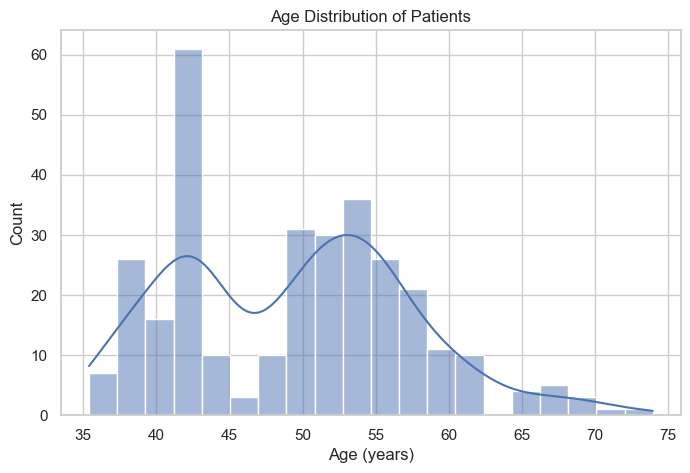

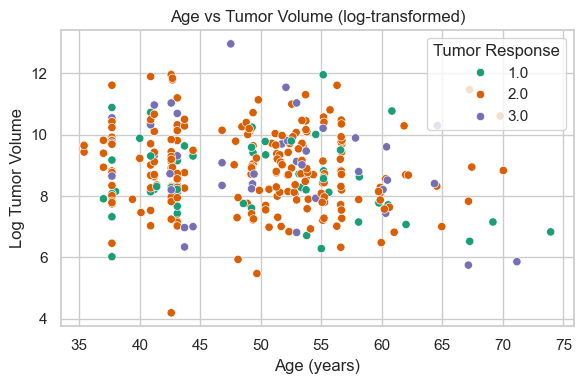

Subgroup Summary Table:
           Breast_Density_real  Volume_cu_mm_Tumor  Log Tumor Volume
Age Group                                                           
<40                      28.80            15586.89              9.02
40–50                    27.98            21388.13              8.96
50–60                    29.54            13806.56              8.83
>60                      37.97            11221.31              8.24


/var/folders/rg/xnr2j4t90f557jdc0qj9lz2m0000gn/T/ipykernel_21028/2090505981.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df.groupby("Age Group")[["Breast_Density_real", "Volume_cu_mm_Tumor", "Log Tumor Volume"]].mean().round(2)


In [43]:
# Ensure Age is numeric before scaling
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Age_years"] = df["Age"] * 10

# Create Age Group bins
df["Age Group"] = pd.cut(df["Age_years"], bins=[0, 40, 50, 60, 80], labels=["<40", "40–50", "50–60", ">60"])

# Create log-transformed tumor volume
df["Log Tumor Volume"] = np.log1p(df["Volume_cu_mm_Tumor"])

# Breast Density fix (assuming it's in decimal, convert to %)
df["Breast_Density_real"] = df["Breast Density"] * 100

# Plot: Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Age_years"], bins=20, kde=True)
plt.title("Age Distribution of Patients")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

# Plot: Age vs Tumor Volume
plt.figure(figsize=(6, 4))
sns.scatterplot(x="Age_years", y="Log Tumor Volume", hue="Tumor Response", data=df, palette="Dark2")
plt.title("Age vs Tumor Volume (log-transformed)")
plt.xlabel("Age (years)")
plt.tight_layout()
plt.show()

# Subgroup summary
summary_table = df.groupby("Age Group")[["Breast_Density_real", "Volume_cu_mm_Tumor", "Log Tumor Volume"]].mean().round(2)
print("Subgroup Summary Table:")
print(summary_table)



In [ ]:
# Check how many Patient IDs from df exist in imaging_df
# matched_ids = df["Patient ID"].isin(imaging_df["Patient ID"])
# print("Number of matches:", matched_ids.sum())

# Show a few IDs from each side to inspect visually
# print("\ndf['Patient ID'].head():")
# print(df["Patient ID"].head())

# print("\nimaging_df['Patient ID'].head():")
# print(imaging_df["Patient ID"].head())


In [45]:
# import os

# files = os.listdir("../Data/raw/")
# print(files)
# for file in files:
#     if file.endswith((".xlsx", ".csv")):
#         try:
#             path = os.path.join("../Data/raw/", file)
#             df_temp = pd.read_excel(path) if file.endswith(".xlsx") else pd.read_csv(path)
#             for col in df_temp.columns:
#                 if "density" in str(col).lower():
#                     print(f"\n Found in: {file}")
#                     print("Column:", col)
#                     print(df_temp[[col]].head())
#         except Exception as e:
#             print(f"Could not read {file}: {e}")


In [ ]:
# Merge breastDensity_T1 if not  present
if "Breast Density" not in df.columns:
    df = df.merge(imaging_df[["Patient ID", "breastDensity_T1"]], on="Patient ID", how="left")
    df.rename(columns={"breastDensity_T1": "Breast Density"}, inplace=True)

# Drop duplicate "Breast Density" columns, if any
breast_density_cols = [col for col in df.columns if col == "Breast Density"]
if len(breast_density_cols) > 1:
    df = df.loc[:, ~df.columns.duplicated()]

# Confirm it's fixed
if "Breast Density" in df.columns:
    print(df[["Patient ID", "Breast Density"]].head())
else:
    print("Breast Density column still missing.")


       Patient ID  Breast Density
0  Breast_MRI_001        0.456428
1  Breast_MRI_002        0.491393
2  Breast_MRI_003        0.256082
4  Breast_MRI_005        0.202973
8  Breast_MRI_009        0.342228


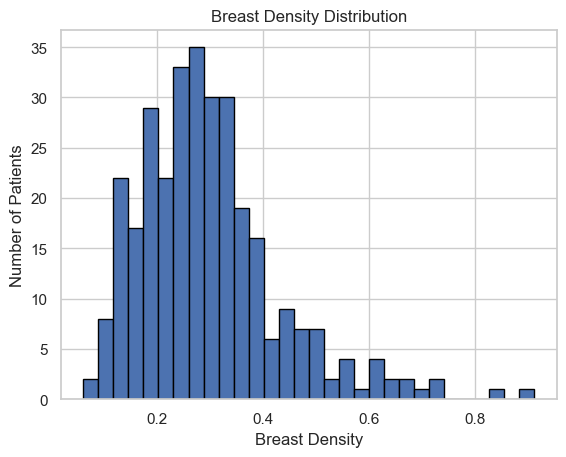

In [14]:
import matplotlib.pyplot as plt

plt.hist(df["Breast Density"], bins=30, edgecolor="black")
plt.title("Breast Density Distribution")
plt.xlabel("Breast Density")
plt.ylabel("Number of Patients")
plt.show()


In [47]:
# print(df["Breast Density"].describe())

In [48]:
# df["Near Complete Response"].value_counts()

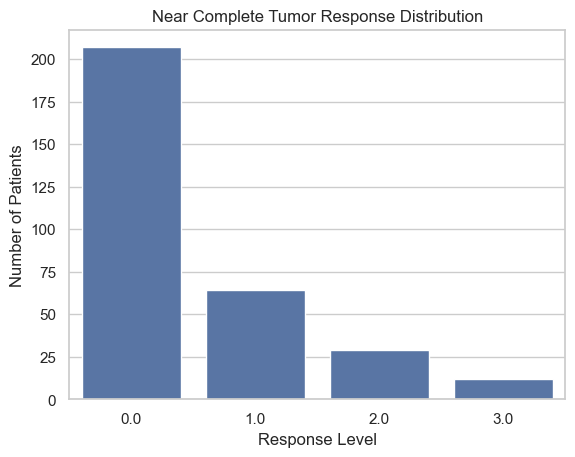

In [17]:
sns.countplot(x="Near Complete Response", data=df)
plt.title("Near Complete Tumor Response Distribution")
plt.xlabel("Response Level")
plt.ylabel("Number of Patients")
plt.show()

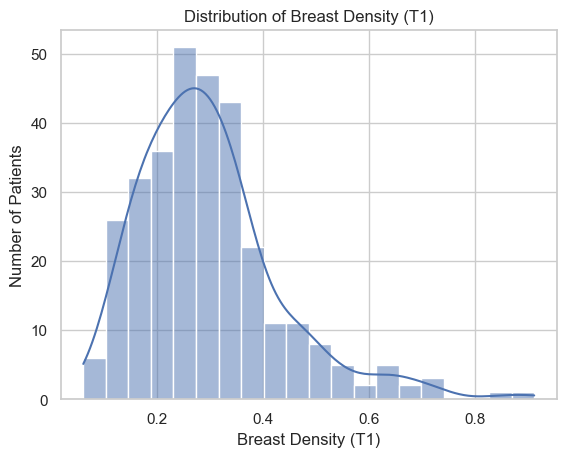

In [18]:
sns.histplot(df["Breast Density"], kde=True)
plt.title("Distribution of Breast Density (T1)")
plt.xlabel("Breast Density (T1)")
plt.ylabel("Number of Patients")
plt.show()


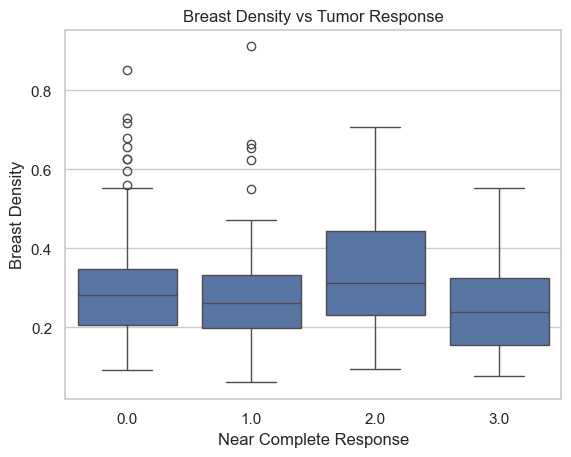

In [19]:
sns.boxplot(x="Near Complete Response", y="Breast Density", data=df)
plt.title("Breast Density vs Tumor Response")
plt.xlabel("Near Complete Response")
plt.ylabel("Breast Density")
plt.show()


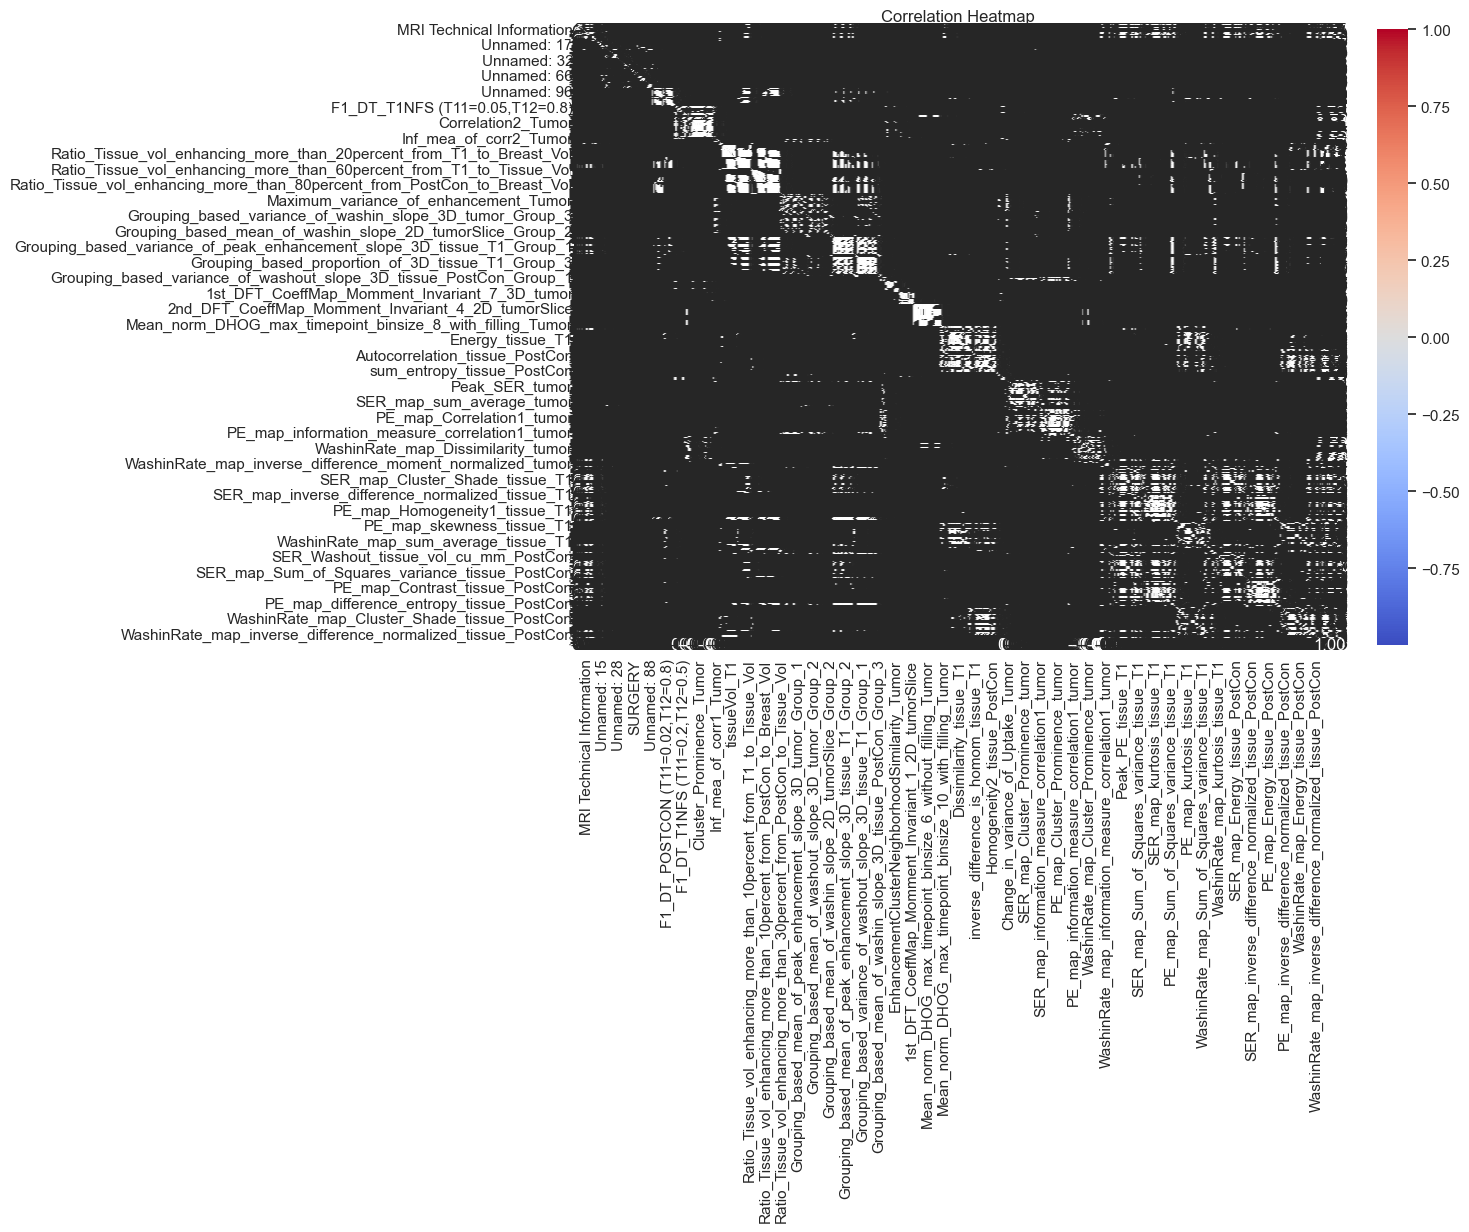

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include="number").corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


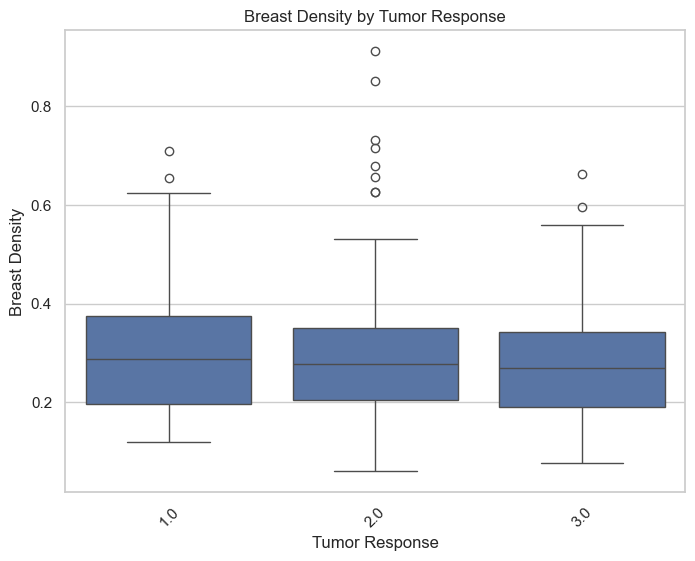

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x="Tumor Response", y="Breast Density", data=df)
plt.title("Breast Density by Tumor Response")
plt.xticks(rotation=45)
plt.show()


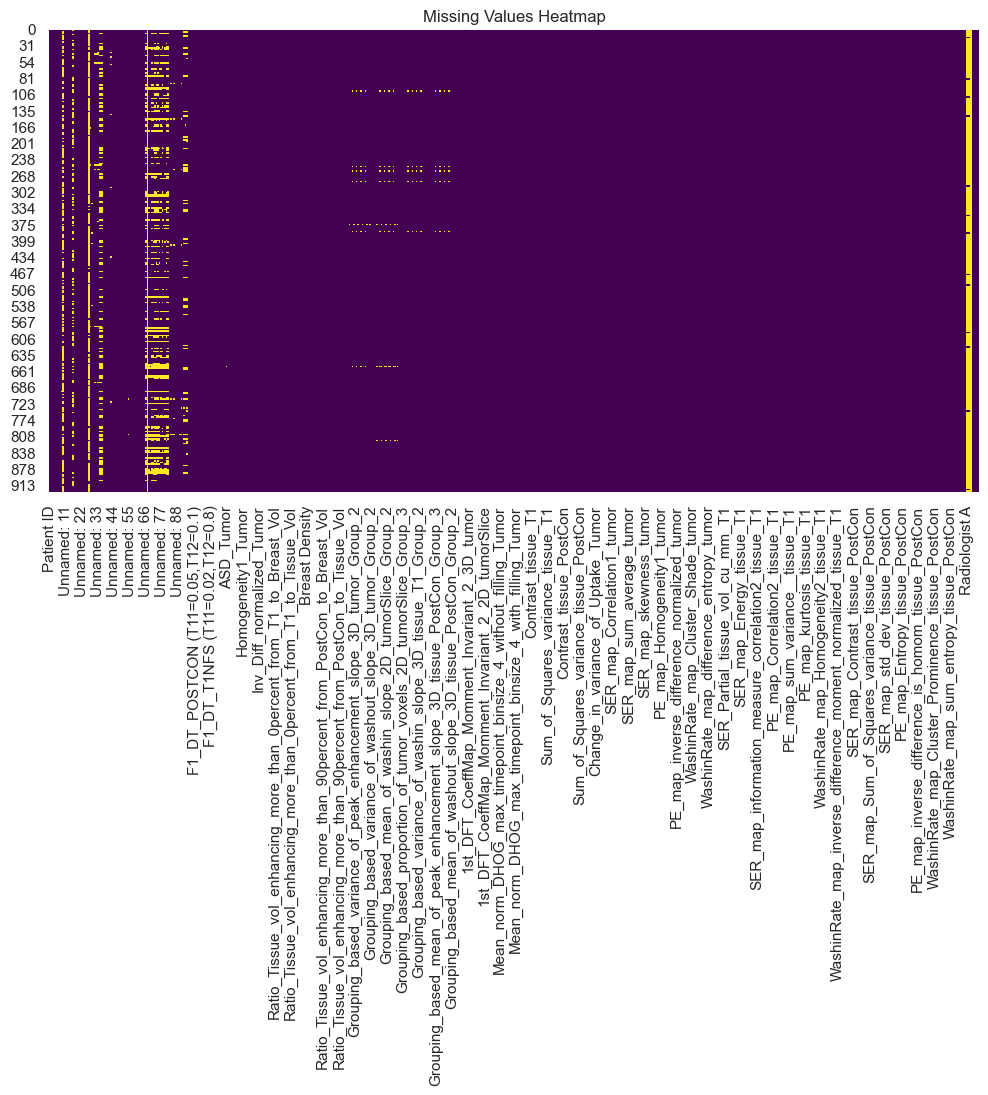

In [22]:
#Missing value heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


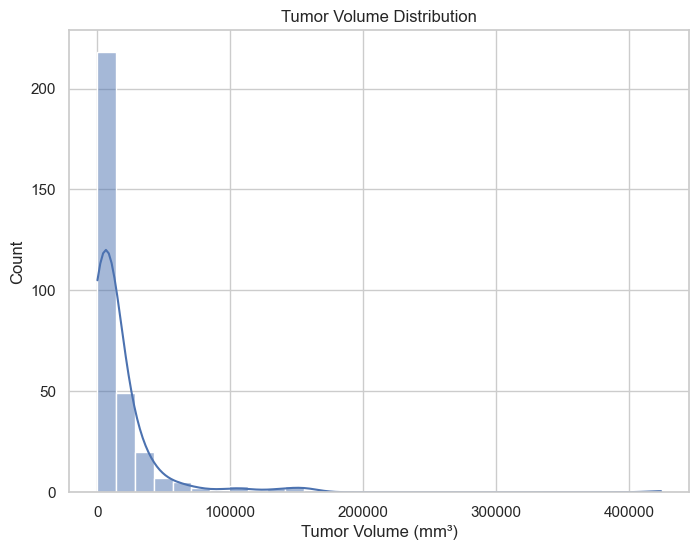

In [23]:
[col for col in df.columns if "volume" in col.lower()]
plt.figure(figsize=(8, 6))
sns.histplot(df["Volume_cu_mm_Tumor"].dropna(), bins=30, kde=True)
plt.title("Tumor Volume Distribution")
plt.xlabel("Tumor Volume (mm³)")
plt.ylabel("Count")
plt.show()


In [ ]:
# [col for col in df.columns if "volume" in col.lower()]
# [col for col in df.columns if "response" in col.lower()]


['Tumor Response',
 'Pathologic Response to Neoadjuvant Therapy',
 'Near Complete Response']

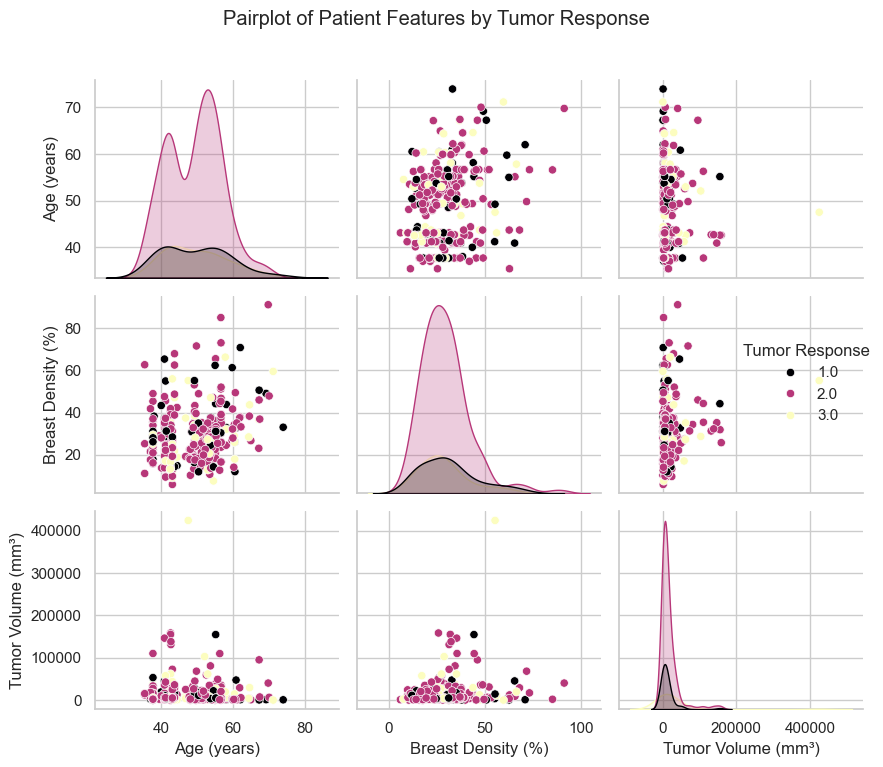

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select corrected columns
plot_df = df[["Age_years", "Breast_Density_real", "Volume_cu_mm_Tumor", "Tumor Response"]].dropna()

# Rename for clarity in plots
plot_df.rename(columns={
    "Age_years": "Age (years)",
    "Breast_Density_real": "Breast Density (%)",
    "Volume_cu_mm_Tumor": "Tumor Volume (mm³)"
}, inplace=True)

# Plot
sns.pairplot(plot_df, hue="Tumor Response", palette="magma", diag_kind="kde")
plt.suptitle("Pairplot of Patient Features by Tumor Response", y=1.02)
plt.tight_layout()
plt.show()


/var/folders/rg/xnr2j4t90f557jdc0qj9lz2m0000gn/T/ipykernel_21028/1322619007.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Tumor Response", data=df, palette="Set2")


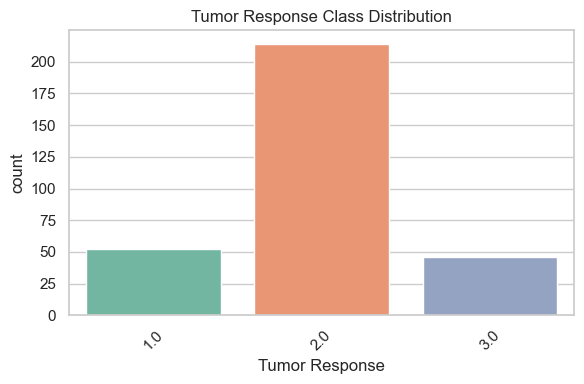

/var/folders/rg/xnr2j4t90f557jdc0qj9lz2m0000gn/T/ipykernel_21028/1322619007.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Tumor Response", y="Log Tumor Volume", data=df, palette="Set3")


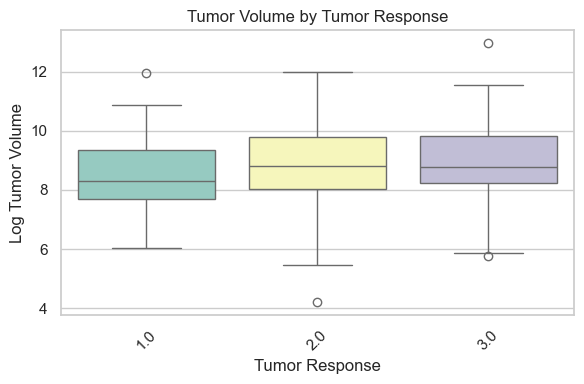

/var/folders/rg/xnr2j4t90f557jdc0qj9lz2m0000gn/T/ipykernel_21028/1322619007.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Age Group", y="Breast_Density_real", data=plot_df, palette="Set2")


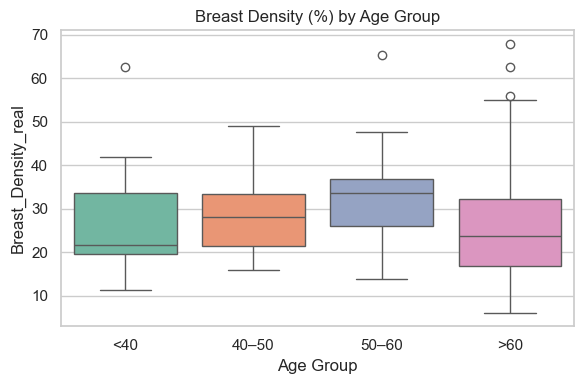

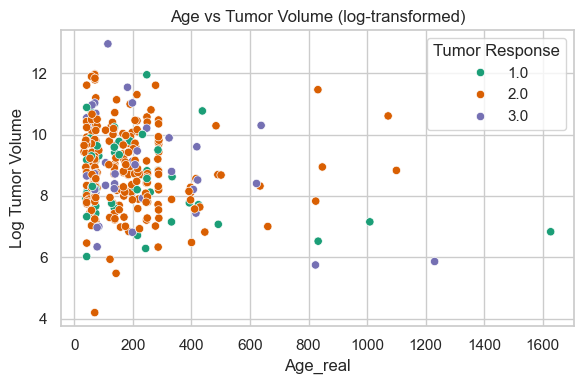

Subgroup Summary Table:
            Breast_Density_real  Volume_cu_mm_Tumor  Log Tumor Volume
Age Group                                                           
<40                      28.85            12059.09              9.26
40–50                    28.24            17088.25              8.96
50–60                    32.71            21519.59              9.10
>60                      26.14            19944.47              8.95


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Reverse log1p transformation on Age
df["Age_real"] = np.expm1(df["Age"]) 

# Scale breast density to percentage
df["Breast_Density_real"] = df["Breast Density"] * 100

# Log transform tumor volume
df["Log Tumor Volume"] = np.log1p(df["Volume_cu_mm_Tumor"])

# Create age groups based on corrected age
df["Age Group"] = pd.cut(df["Age_real"], bins=[20, 40, 50, 60, 80],labels=["<40", "40–50", "50–60", ">60"])

# Plot 1: Tumor Response Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Tumor Response", data=df, palette="Set2")
plt.title("Tumor Response Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Tumor Volume by Tumor Response
plt.figure(figsize=(6, 4))
sns.boxplot(x="Tumor Response", y="Log Tumor Volume", data=df, palette="Set3")
plt.title("Tumor Volume by Tumor Response")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Breast Density (%) by Age Group
plot_df = df[["Age Group", "Breast_Density_real"]].dropna()
plt.figure(figsize=(6, 4))
sns.boxplot(x="Age Group", y="Breast_Density_real", data=plot_df, palette="Set2")
plt.title("Breast Density (%) by Age Group")
plt.tight_layout()
plt.show()

# Plot 4: Age vs Tumor Volume (log)
plt.figure(figsize=(6, 4))
sns.scatterplot(x="Age_real", y="Log Tumor Volume", hue="Tumor Response", data=df, palette="Dark2")
plt.title("Age vs Tumor Volume (log-transformed)")
plt.tight_layout()
plt.show()

# Subgroup Summary Table
summary_table = df.groupby("Age Group",observed=False)[["Breast_Density_real", "Volume_cu_mm_Tumor", "Log Tumor Volume"]].mean().round(2)
print("Subgroup Summary Table:\n", summary_table)


In [27]:
#checks
print(df["Volume_cu_mm_Tumor"].dtype)
print(df["Volume_cu_mm_Tumor"].describe())
print(df["Volume_cu_mm_Tumor"].isnull().sum())

print(df["Breast_Density_real"].dtype)
print(df["Breast_Density_real"].describe())
print(df["Breast_Density_real"].isnull().sum())
print(((df["Breast_Density_real"] < 0) | (df["Breast_Density_real"] > 100)).sum())


print(df["Tumor Response"].unique())
print(df["Tumor Response"].isnull().sum())


float64
count       312.000000
mean      16736.276891
std       34229.297300
min          65.432814
25%        3004.646145
50%        6382.689136
75%       16917.175125
max      424316.270160
Name: Volume_cu_mm_Tumor, dtype: float64
0
float64
count    312.000000
mean      29.627104
std       13.351486
min        6.024564
25%       20.258236
50%       27.957222
75%       35.128930
max       91.145129
Name: Breast_Density_real, dtype: float64
0
0
[2. 1. 3.]
0
